# CSC_52081_EP Project

Advanced Machine Learning and Autonomous Agents Project

## Introduction

Reinforcement Learning (RL) has emerged as a robust framework for training autonomous agents to learn optimal behaviors through environmental interactions. This study utilizes the [`CarRacing-v3`](https://gymnasium.farama.org/environments/box2d/car_racing/) environment from Gymnasium, which presents a challenging control task in a racing scenario.

### Environment

The environment features a high-dimensional observation space, represented by a $96 \times 96$ RGB image capturing the car and track, necessitating the use of deep convolutional neural networks (CNNs) for effective feature extraction.

#### Action Space

The action space in CarRacing-v3 supports both continuous and discrete control modes.

In **continuous mode**, the agent outputs three real-valued commands:

- steering (ranging from $-1$ to $+1$)
- gas
- braking

In **discrete mode**, the action space is simplified to five actions:

- do nothing
- steer left
- steer right
- gas
- brake

This dual action representation enables a comprehensive evaluation of various RL algorithms under different control settings.

#### Reward

The reward structure combines a penalty of $-0.1$ per frame and a reward of $+\frac{1000}{N}$ for each new track tile visited, where $N$ is the total number of tiles. This incentivizes the agent to balance exploration (visiting tiles) with efficiency (minimizing frame usage). For example, completing the race after visiting all $N$ tiles in 732 frames yields a reward of $1000 - 0.1 \times 732 = 926.8$ points.

#### CNN

### Objective

The primary objective of this project is to compare RL policies across discrete and continuous action modalities. For discrete control, methods like **Deep Q-Network** (DQN) and **SARSA** are implemented, while continuous control is explored using approaches such as the **Cross-Entropy Method** (CEM), **Self-Adaptive Evolution Strategy** (SA-ES), and policy gradient techniques like **Proximal Policy Optimization** (PPO) and **Soft Actor-Critic** (SAC). This comparative analysis aims to understand the strengths and limitations of each method in handling complex decision spaces.

The high-dimensional visual inputs in `CarRacing-v3` require effective feature extraction, addressed through a tailored CNN architecture. Transitioning between discrete and continuous action representations also demands careful algorithmic design and parameter tuning to ensure stable learning and convergence. While prior studies have often focused on either discrete or continuous action spaces separately, this work adopts a comparative approach, evaluating different agents within the same environment to assess performance under similar conditions.

At this stage, the work outlines the methodology and anticipated challenges, focusing on designing the CNN-based feature extractor, implementing RL algorithms, and establishing a framework for performance comparison. Preliminary findings are yet to be finalized, but the study is expected to provide insights into applying RL in high-dimensional, real-time control tasks. Limitations include the preliminary nature of experiments and the need for further tuning and validation. Future work will involve extensive empirical evaluations, exploring additional policy gradient methods, and refining the network architecture to better handle the complexities of `CarRacing-v3`.

### GitHub

The project's code is available on [GitHub](https://github.com/tr0fin0/ensta_CSC_52081_EP_project), offering a reproducible framework for future investigations and extensions.

## Installation

### Environment

#### WSL, Linux or MacOS

A `Python Virtual Environment` will be used for this project by run the following on a terminal on the project folder:

```bash
sudo apt install python3.10-venv
python3 -m venv env
source env/bin/activate
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements.txt
```

### Setup

In [ ]:
import datetime
import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import torch
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.ion()
sns.set_context("talk")


from IPython.display import Video
from pathlib import Path
from typing import List



DIRECTORY_OUTPUT = "output"
DIRECTORY_MODELS = Path(f"{DIRECTORY_OUTPUT}/models/")
DIRECTORY_FIGURES = Path(f"{DIRECTORY_OUTPUT}/images/")
DIRECTORY_LOGS = Path(f"{DIRECTORY_OUTPUT}/logs/")

if not DIRECTORY_FIGURES.exists():
    DIRECTORY_FIGURES.mkdir(parents=True)

if not DIRECTORY_MODELS.exists():
    DIRECTORY_MODELS.mkdir(parents=True)

if not DIRECTORY_LOGS.exists():
    DIRECTORY_LOGS.mkdir(parents=True)

print(DIRECTORY_OUTPUT)
print(DIRECTORY_MODELS)
print(DIRECTORY_FIGURES)
print(DIRECTORY_LOGS)

## Demonstration

In [ ]:
from utils import get_environment_discrete

VIDEO_DEMO = "CSC_52081_EP_demonstration"
(DIRECTORY_FIGURES / f"{VIDEO_DEMO}.mp4").unlink(missing_ok=True)


env_discrete = get_environment_discrete()
env_discrete = gym.wrappers.RecordVideo(
    env_discrete, video_folder=str(DIRECTORY_FIGURES), name_prefix=VIDEO_DEMO
)
observation, info = env_discrete.reset()


done = False
while not done:
    action = env_discrete.action_space.sample() # random action

    observation, reward, terminated, truncated, info = env_discrete.step(action)
    done = terminated or truncated

env_discrete.close()


Video(
    DIRECTORY_FIGURES / f"{VIDEO_DEMO}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)

## Algorithm, DQN

### DQN

#### Agent

#### Training

In [ ]:
from Agent_DQN import Agent_DQN
from CNN import CNN
from utils import get_environment, plot_reward


MODEL_LOAD = True
MODEL_ID = 400000

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCHES = 32
EPISODES = 3000
EPISODES_EXTRA = 300

env_discrete = get_environment(is_continuous=False)
state, info = env_discrete.reset()

agent = Agent_DQN(
    state.shape,
    env_discrete.action_space.n,
    DEVICE,
    DIRECTORY_MODELS,
    DIRECTORY_LOGS,
    CNN,
    load_state='train' if MODEL_LOAD else None,
    load_model= f'DQN_{MODEL_ID}.pt' if MODEL_LOAD else None,
    use_DDQN=False
)


episode = EPISODES if MODEL_LOAD else 0
actions = MODEL_ID if MODEL_LOAD else 0
episode_epsilons = []
episode_rewards = []
episode_lengths = []
episode_losses = []
episode_dates = []
episode_times = []

interval_learn = 4      # [actions]
interval_sync = 5000    # [actions]
interval_save = 10000   # [actions]
interval_log = 10       # [episodes]


while episode <= EPISODES + (EPISODES_EXTRA if MODEL_LOAD else 0):
    episode += 1
    episode_reward = 0
    episode_length = 0

    done = False
    losses = []
    episode_epsilons.append(agent.epsilon)

    while not done:
        actions += 1
        episode_length += 1

        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env_discrete.step(action)
 
        episode_reward += reward
        agent.store(state, action, reward, next_state, terminated)

        state = next_state
        done = terminated or truncated

        if actions % interval_sync == 0:
            updating_network_parameters = agent.updating_network.state_dict()
            agent.frozen_network.load_state_dict(updating_network_parameters)

        if actions % interval_save == 0:
            agent.save()

        if actions % interval_learn == 0:
            q, loss = agent.update_network(BATCHES)
            losses.append(loss)


    state, info = env_discrete.reset()

    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    episode_losses.append(np.mean(losses))
    now_time = datetime.datetime.now()
    episode_dates.append(now_time.date().strftime('%Y-%m-%d'))
    episode_times.append(now_time.time().strftime('%H:%M:%S'))

    plot_reward(episode, episode_rewards, actions)

    if episode % interval_log == 0:
        agent.write_log(
            episode_dates,
            episode_times,
            episode_rewards,
            episode_lengths,
            episode_losses,
            episode_epsilons,
        )

agent.save()
agent.write_log(
    episode_dates,
    episode_times,
    episode_rewards,
    episode_lengths,
    episode_losses,
    episode_epsilons,
)
env_discrete.close()

plt.ioff()
plt.show()

#### Evaluation

output
output/models
output/images
output/logs
Episode:0, Score:868.65, actions: 3
Episode:1, Score:921.70, actions: 2
Episode:2, Score:816.42, actions: 4
Episode:3, Score:885.24, actions: 4
Episode:4, Score:892.73, actions: 2
Episode:5, Score:884.80, actions: 3
Episode:6, Score:906.90, actions: 3
Episode:7, Score:852.98, actions: 4
Episode:8, Score:930.40, actions: 2
Episode:9, Score:922.00, actions: 4
Episode:10, Score:922.30, actions: 3
Episode:11, Score:892.28, actions: 4
Episode:12, Score:860.40, actions: 3
Episode:13, Score:922.60, actions: 3
Episode:14, Score:883.05, actions: 2
Episode:15, Score:914.60, actions: 2
Episode:16, Score:882.82, actions: 4
Episode:17, Score:870.10, actions: 3
Episode:18, Score:890.42, actions: 3
Episode:19, Score:688.57, actions: 4
Episode:20, Score:832.69, actions: 4
Episode:21, Score:870.41, actions: 4
Episode:22, Score:863.30, actions: 3
Episode:23, Score:869.59, actions: 3
Episode:24, Score:873.86, actions: 2
Episode:0, Score:868.65, actions: 3
Ep

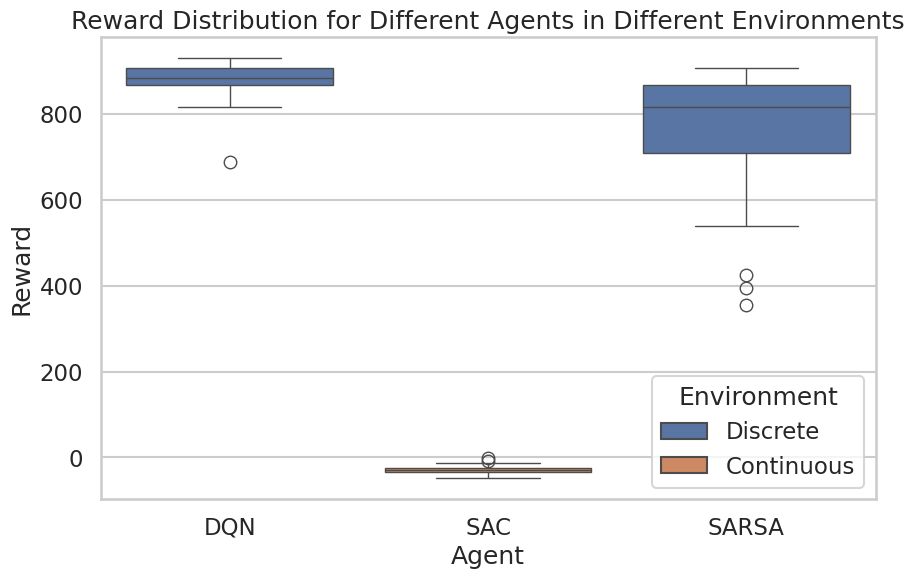

In [11]:
from Agent_DQN import Agent_DQN
from Agent_DeepSARSA import DeepSARSA
from Agent_PPO import PPO
from Agent_SAC import AgentSAC
from CNN import CNN
from utils import agent_evaluation, get_environment

import pandas as pd
import datetime
import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import torch
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.ion()
sns.set_context("talk")


from IPython.display import Video
from pathlib import Path
from typing import List



DIRECTORY_OUTPUT = "output"
DIRECTORY_MODELS = Path(f"{DIRECTORY_OUTPUT}/models/")
DIRECTORY_FIGURES = Path(f"{DIRECTORY_OUTPUT}/images/")
DIRECTORY_LOGS = Path(f"{DIRECTORY_OUTPUT}/logs/")

if not DIRECTORY_FIGURES.exists():
    DIRECTORY_FIGURES.mkdir(parents=True)

if not DIRECTORY_MODELS.exists():
    DIRECTORY_MODELS.mkdir(parents=True)

if not DIRECTORY_LOGS.exists():
    DIRECTORY_LOGS.mkdir(parents=True)

print(DIRECTORY_OUTPUT)
print(DIRECTORY_MODELS)
print(DIRECTORY_FIGURES)
print(DIRECTORY_LOGS)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEEDS = [i for i in range(25)]


env_discrete = get_environment(is_continuous=False)
state, info = env_discrete.reset()

agent_DQN = Agent_DQN(
    state.shape,
    env_discrete.action_space.n,
    DEVICE,
    DIRECTORY_MODELS,
    DIRECTORY_LOGS,
    CNN,
    load_state='eval',
    load_model= f'DQN_{474290}.pt',
    use_DDQN=False
)
scores_DQN, _ = agent_evaluation(agent_DQN, env_discrete, SEEDS)
scores_DQN, _ = agent_evaluation(agent_DQN, env_discrete, SEEDS)
scores_DQN, _ = agent_evaluation(agent_DQN, env_discrete, SEEDS)
scores_DQN, _ = agent_evaluation(agent_DQN, env_discrete, SEEDS)

agent_SARSA = DeepSARSA(
    env_discrete,
    DEVICE,
    DIRECTORY_MODELS,
    DIRECTORY_LOGS,
    CNN
)
agent_SARSA.load(f"DEEP_SARSA_{249117}.pt")
scores_SARSA, _ = agent_evaluation(agent_SARSA, env_discrete, SEEDS)
scores_SARSA, _ = agent_evaluation(agent_SARSA, env_discrete, SEEDS)
scores_SARSA, _ = agent_evaluation(agent_SARSA, env_discrete, SEEDS)
scores_SARSA, _ = agent_evaluation(agent_SARSA, env_discrete, SEEDS)



env_continuous = get_environment(is_continuous=True)
state, info = env_continuous.reset()

# agent_PPO = PPO(
#     env_continuous,
#     DEVICE,
#     DIRECTORY_MODELS
# )
# agent_PPO.load(f"PPO_{37616}")
# scores, _ = agent_evaluation(agent_PPO, env_continuous, SEEDS)


agent_SAC = AgentSAC(
    state.shape,
    env_continuous.action_space,
    DEVICE,
    DIRECTORY_MODELS,
    DIRECTORY_LOGS,
    CNN,
    load_state='eval',
    load_model= f'SAC_{27500}.pt',
)
scores_SAC, _ = agent_evaluation(agent_SAC, env_continuous, SEEDS)
scores_SAC, _ = agent_evaluation(agent_SAC, env_continuous, SEEDS)
scores_SAC, _ = agent_evaluation(agent_SAC, env_continuous, SEEDS)
scores_SAC, _ = agent_evaluation(agent_SAC, env_continuous, SEEDS)


# Create a DataFrame to hold the scores for each agent in different environments
scores_df = pd.DataFrame({
    'Agent': ['DQN'] * len(scores_DQN) + ['SAC'] * len(scores_SAC) + ['SARSA'] * len(scores_SARSA),
    'Environment': ['Discrete'] * len(scores_DQN) + ['Continuous'] * len(scores_SAC) + ['Discrete'] * len(scores_SARSA),
    'Scores': scores_DQN + scores_SAC + scores_SARSA
})
# Read the benchmark.csv file
benchmark_df = pd.read_csv('benchmark.csv')

# Append the benchmark scores to the scores_df DataFrame
scores_df = pd.concat([scores_df, benchmark_df], ignore_index=True)

# Plot the scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='Agent', y='Scores', hue='Environment', data=scores_df)
plt.title('Reward Distribution for Different Agents in Different Environments')
plt.xlabel('Agent')
plt.ylabel('Reward')
plt.legend(title='Environment')
plt.show()


/tmp/ipykernel_165574/2823139423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='agent', y='reward', data=grouped_df, palette='Set2')


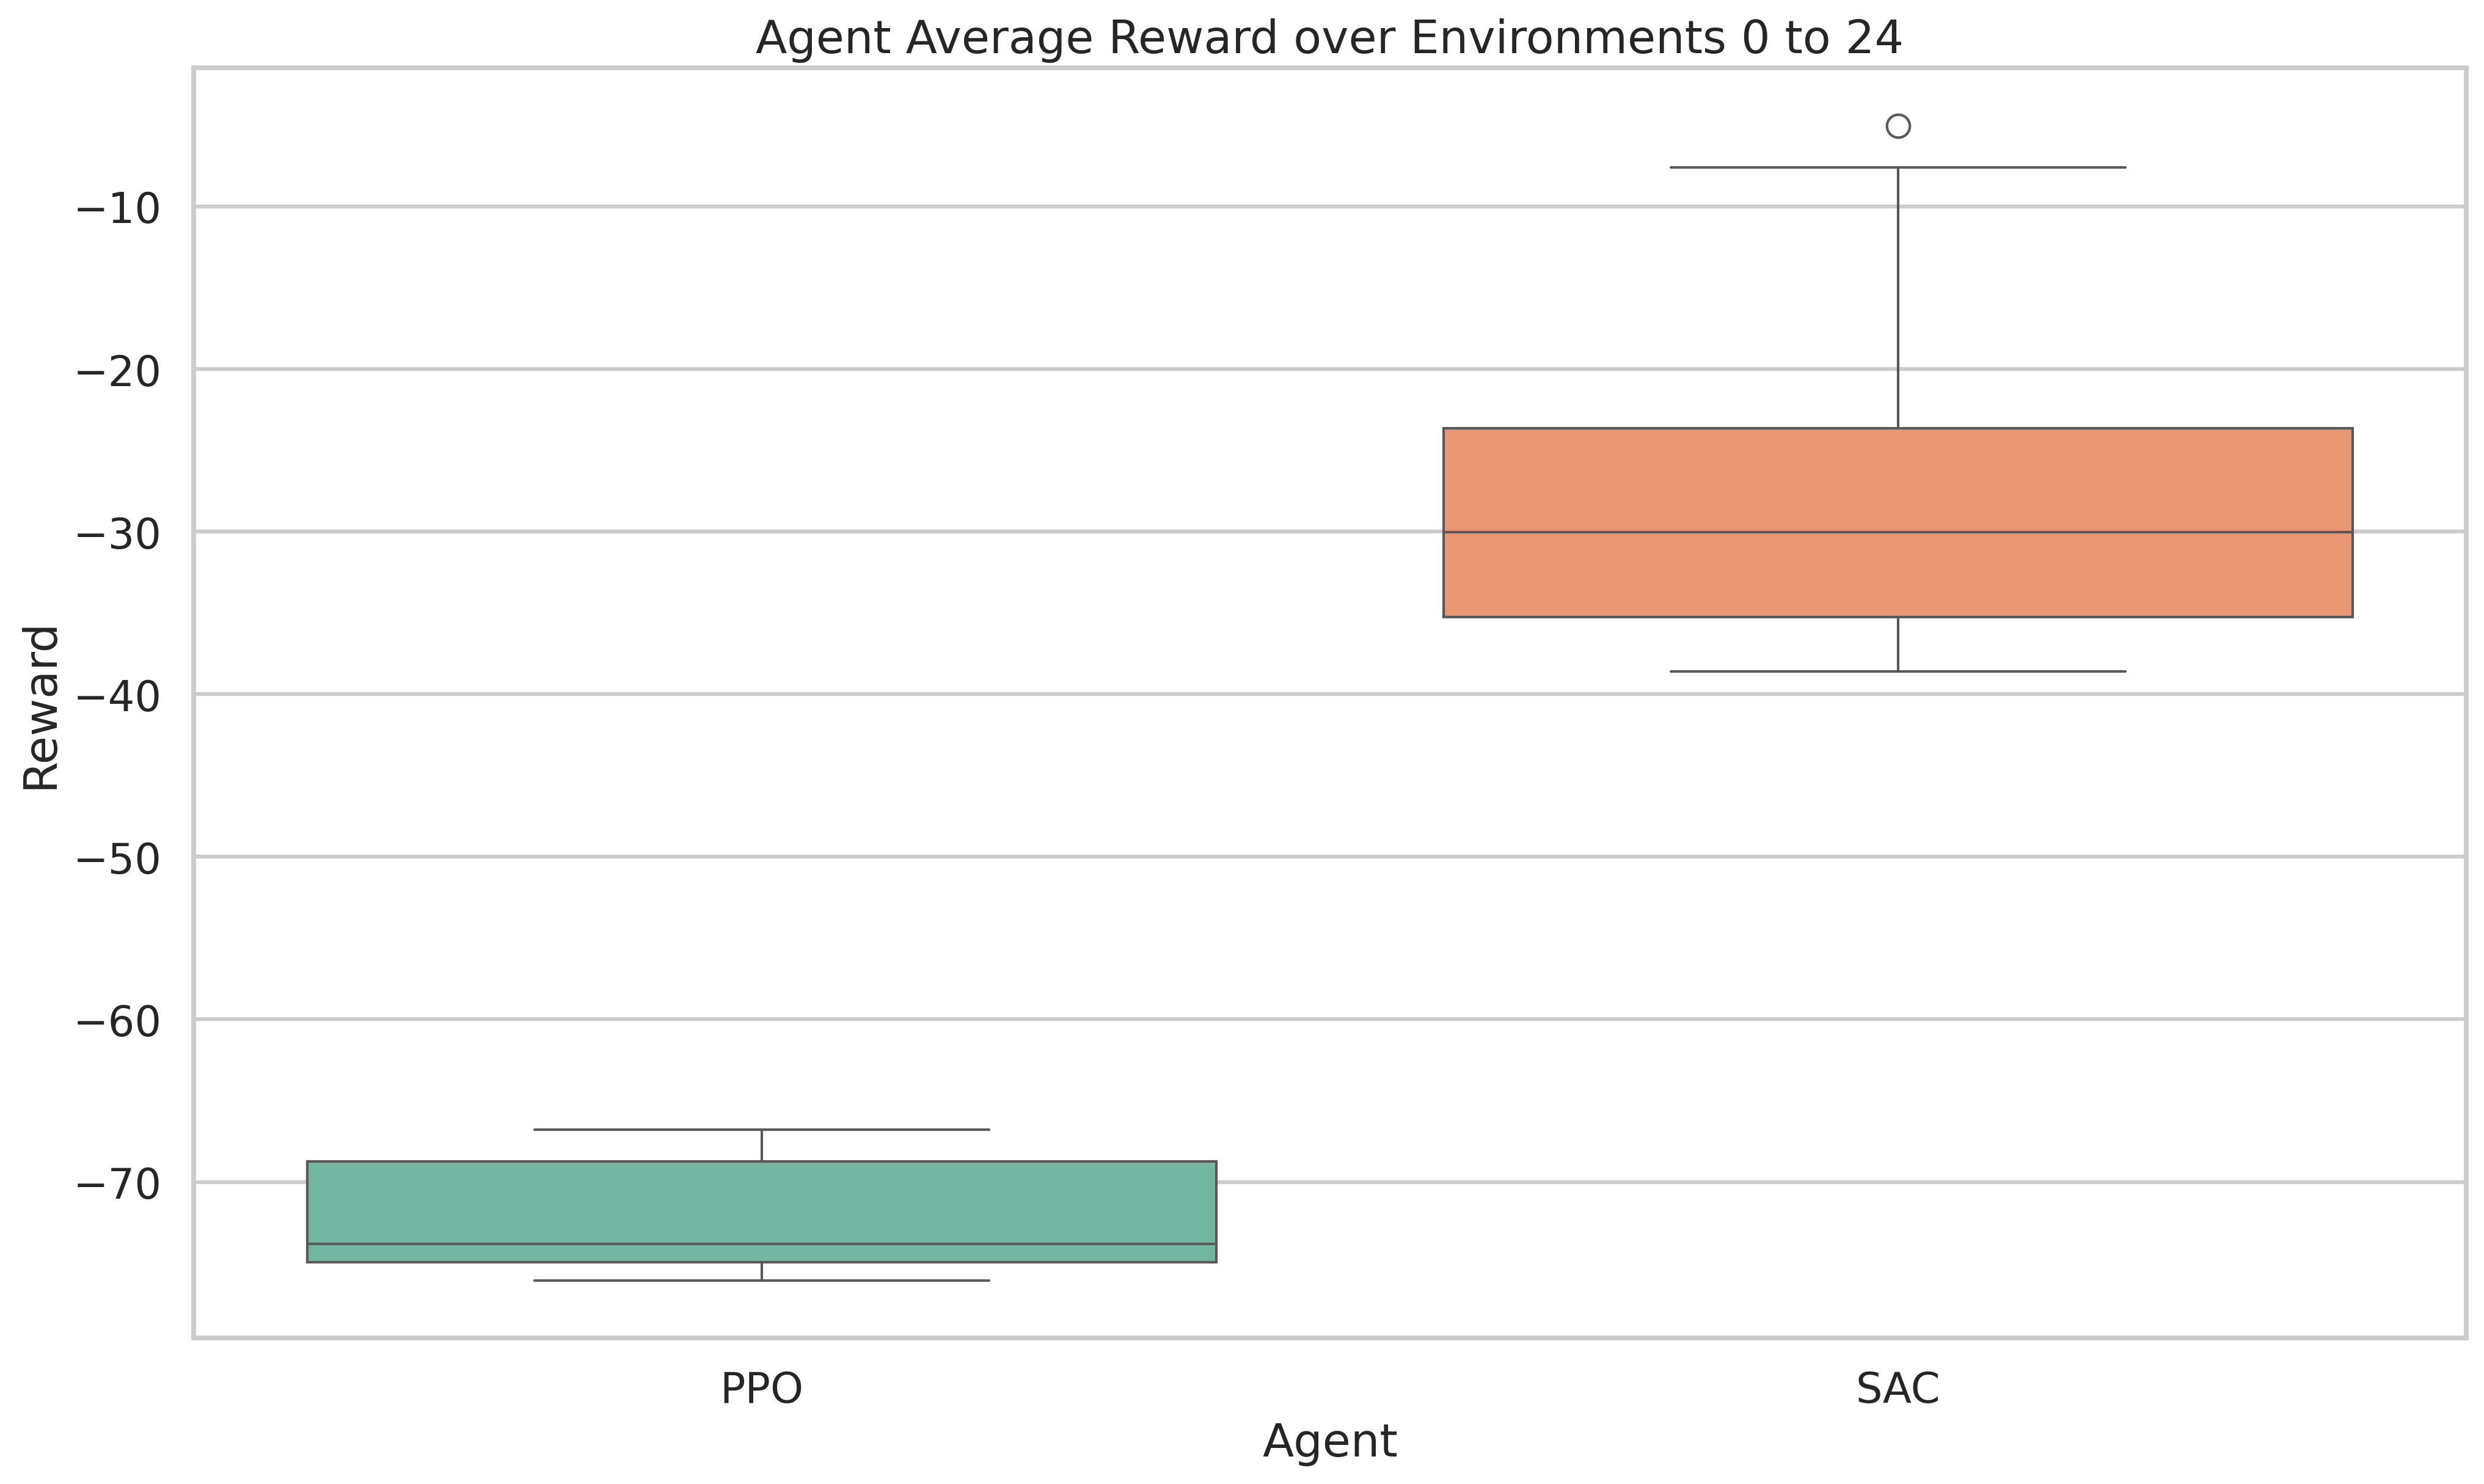

In [35]:
benchmark_df = pd.read_csv('benchmark.csv')
grouped_df = benchmark_df.groupby(['agent', 'environment']).mean().reset_index()
grouped_df = grouped_df[grouped_df['agent'].isin(['PPO', 'SAC'])]

# Plot the scores
plt.figure(figsize=(16, 9), dpi=300)
sns.boxplot(x='agent', y='reward', data=grouped_df, palette='Set2')
plt.title('Agent Average Reward over Environments 0 to 24')
plt.xlabel('Agent')
plt.ylabel('Reward')
plt.show()

    agent  environment     min     max    mean
0     DQN            0  868.65  868.65  868.65
1     DQN            1  921.70  921.70  921.70
2     DQN            2  816.42  816.42  816.42
3     DQN            3  885.24  885.24  885.24
4     DQN            4  892.73  892.73  892.73
5     DQN            5  884.80  884.80  884.80
6     DQN            6  906.90  906.90  906.90
7     DQN            7  852.98  852.98  852.98
8     DQN            8  930.40  930.40  930.40
9     DQN            9  922.00  922.00  922.00
10    DQN           10  922.30  922.30  922.30
11    DQN           11  892.28  892.28  892.28
12    DQN           12  860.40  860.40  860.40
13    DQN           13  922.60  922.60  922.60
14    DQN           14  883.05  883.05  883.05
15    DQN           15  914.60  914.60  914.60
16    DQN           16  882.82  882.82  882.82
17    DQN           17  870.10  870.10  870.10
18    DQN           18  890.42  890.42  890.42
19    DQN           19  688.57  688.57  688.57
20    DQN    

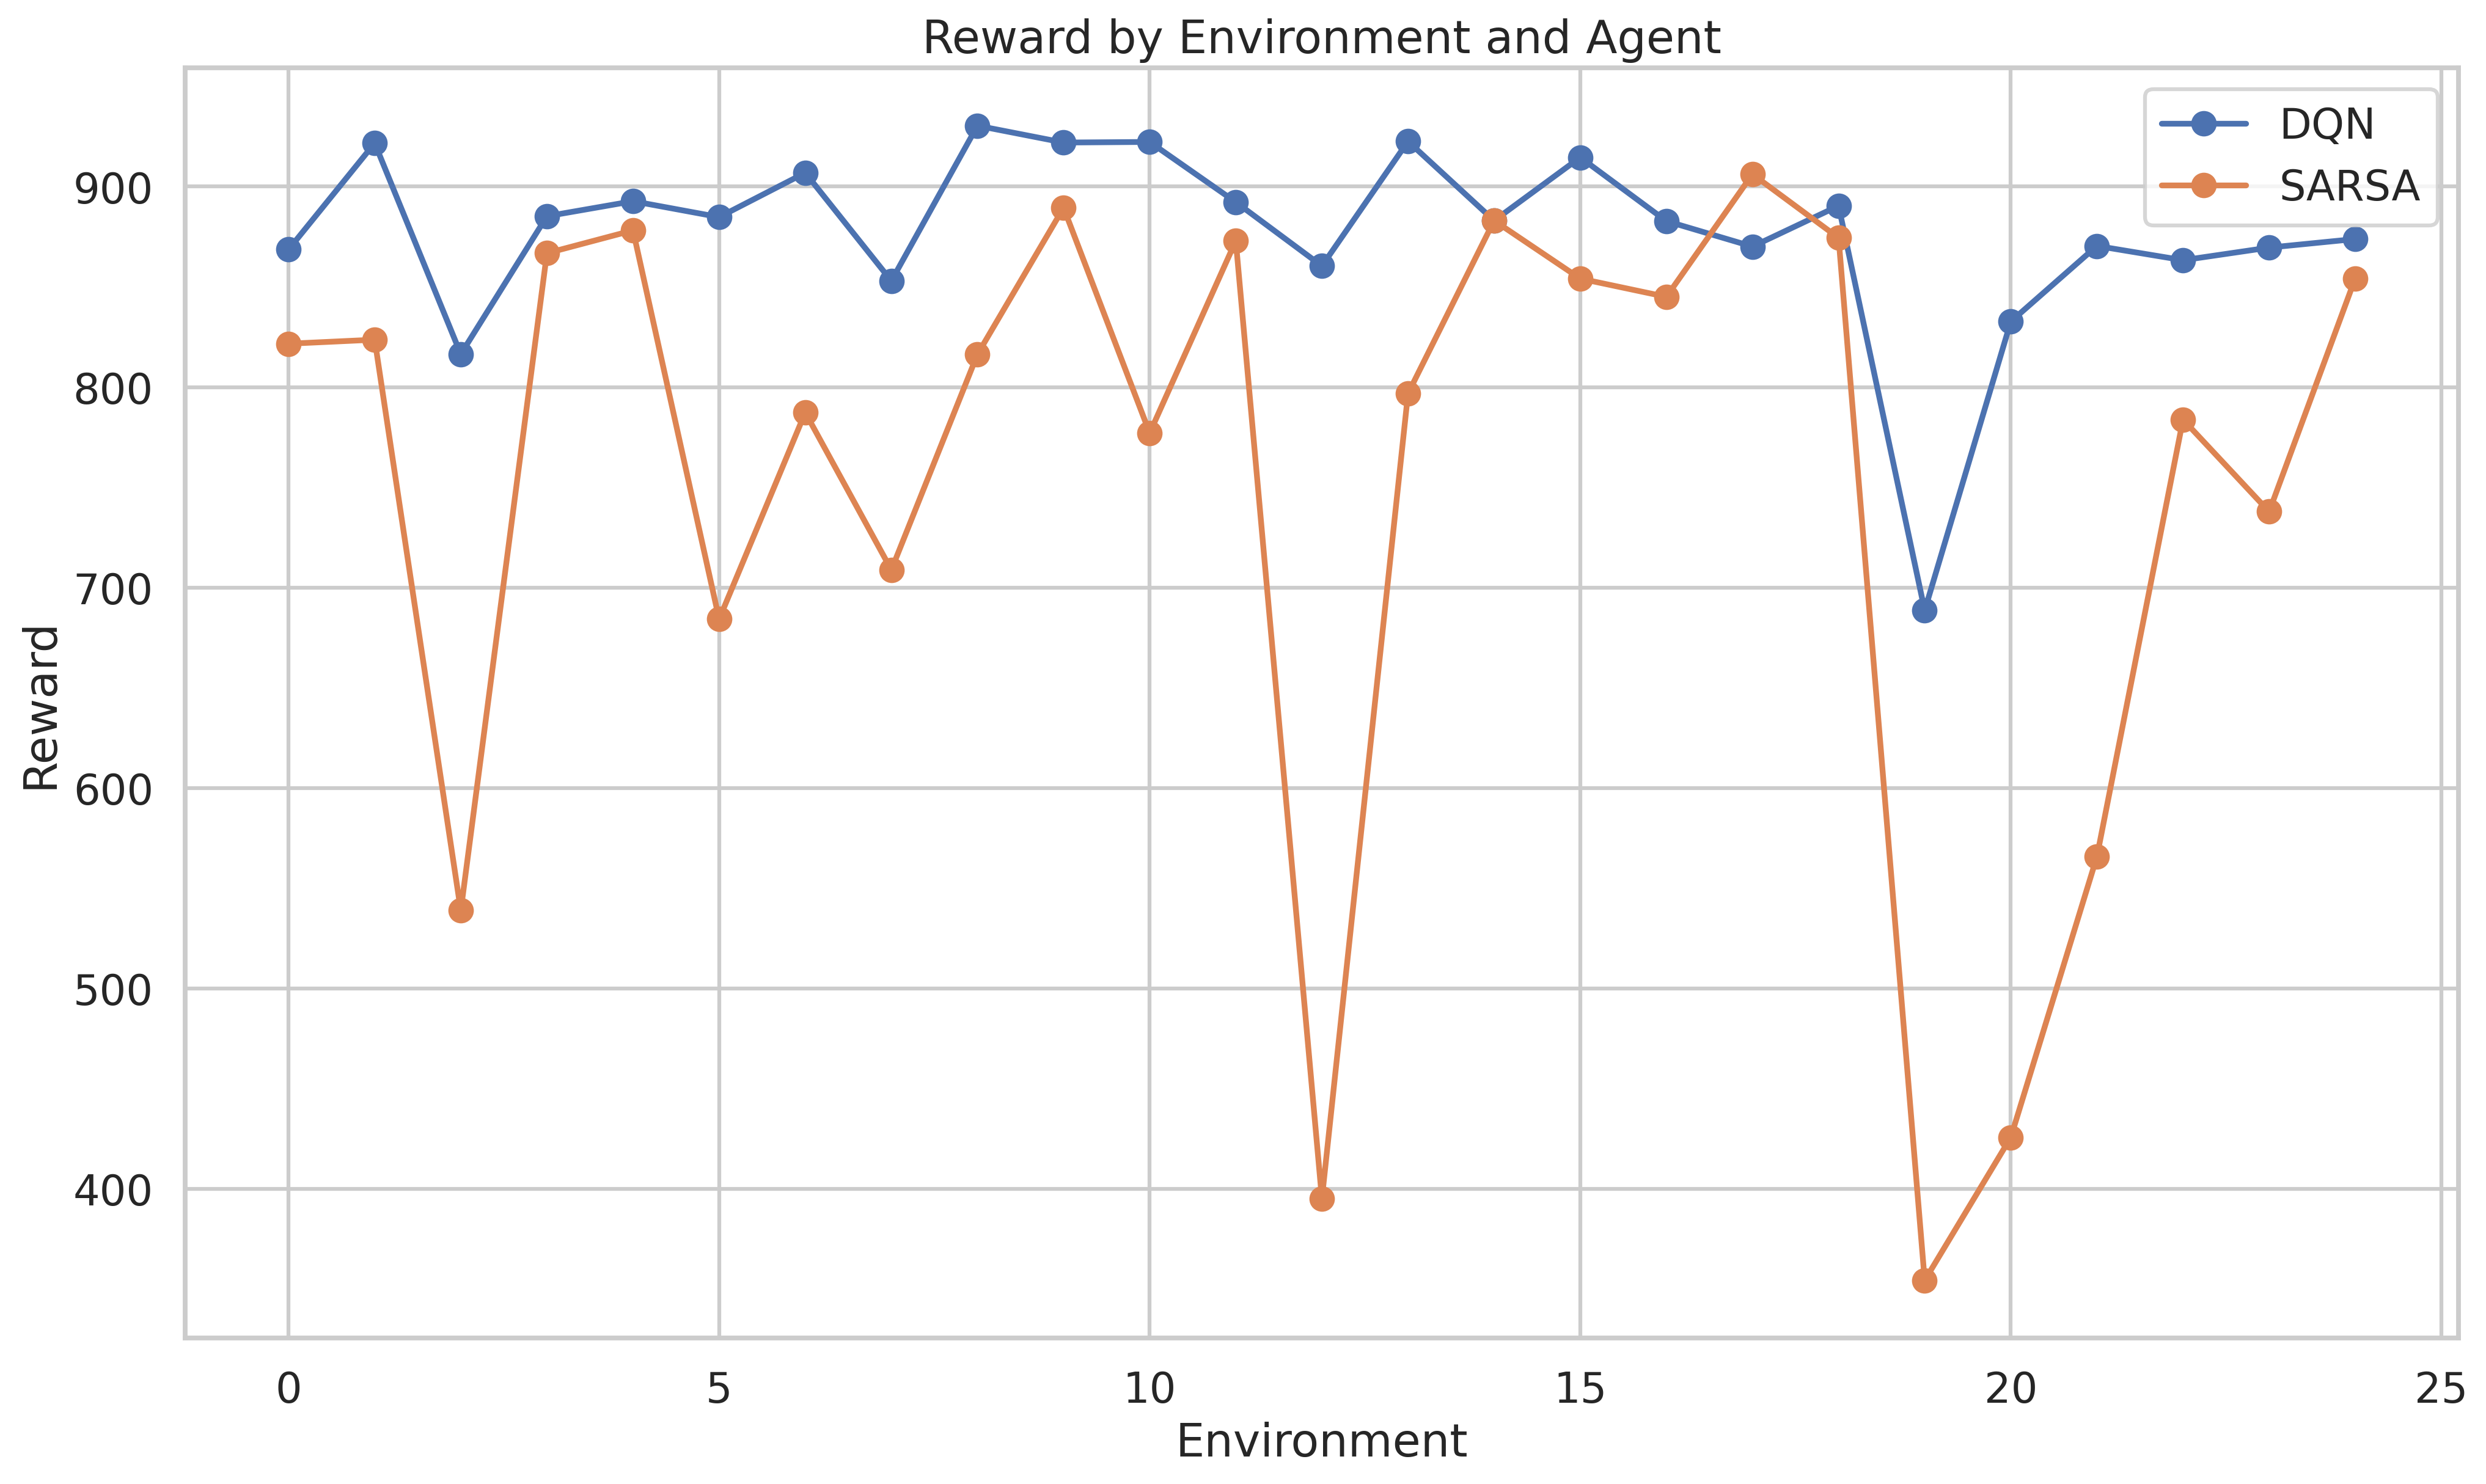

In [36]:
df = pd.read_csv('benchmark.csv')
grouped = df.groupby(['agent', 'environment'])['reward'].agg(['min', 'max', 'mean']).reset_index()
grouped = grouped[grouped['agent'].isin(['DQN', 'SARSA'])]

print(grouped)
# Plotting
plt.figure(figsize=(16, 9), dpi=300)
for agent in grouped['agent'].unique():
    agent_data = grouped[grouped['agent'] == agent]
    plt.plot(agent_data['environment'], agent_data['mean'], label=f'{agent}', marker='o')
    plt.fill_between(agent_data['environment'], agent_data['min'], agent_data['max'], alpha=0.2)

# Add labels and title
plt.xlabel('Environment')
plt.ylabel('Reward')
plt.title('Reward by Environment and Agent')
plt.legend()
plt.grid(True)
plt.show()

    agent  environment     min     max    mean
0     DQN            0  868.65  868.65  868.65
1     DQN            1  921.70  921.70  921.70
2     DQN            2  816.42  816.42  816.42
3     DQN            3  885.24  885.24  885.24
4     DQN            4  892.73  892.73  892.73
5     DQN            5  884.80  884.80  884.80
6     DQN            6  906.90  906.90  906.90
7     DQN            7  852.98  852.98  852.98
8     DQN            8  930.40  930.40  930.40
9     DQN            9  922.00  922.00  922.00
10    DQN           10  922.30  922.30  922.30
11    DQN           11  892.28  892.28  892.28
12    DQN           12  860.40  860.40  860.40
13    DQN           13  922.60  922.60  922.60
14    DQN           14  883.05  883.05  883.05
15    DQN           15  914.60  914.60  914.60
16    DQN           16  882.82  882.82  882.82
17    DQN           17  870.10  870.10  870.10
18    DQN           18  890.42  890.42  890.42
19    DQN           19  688.57  688.57  688.57
20    DQN    

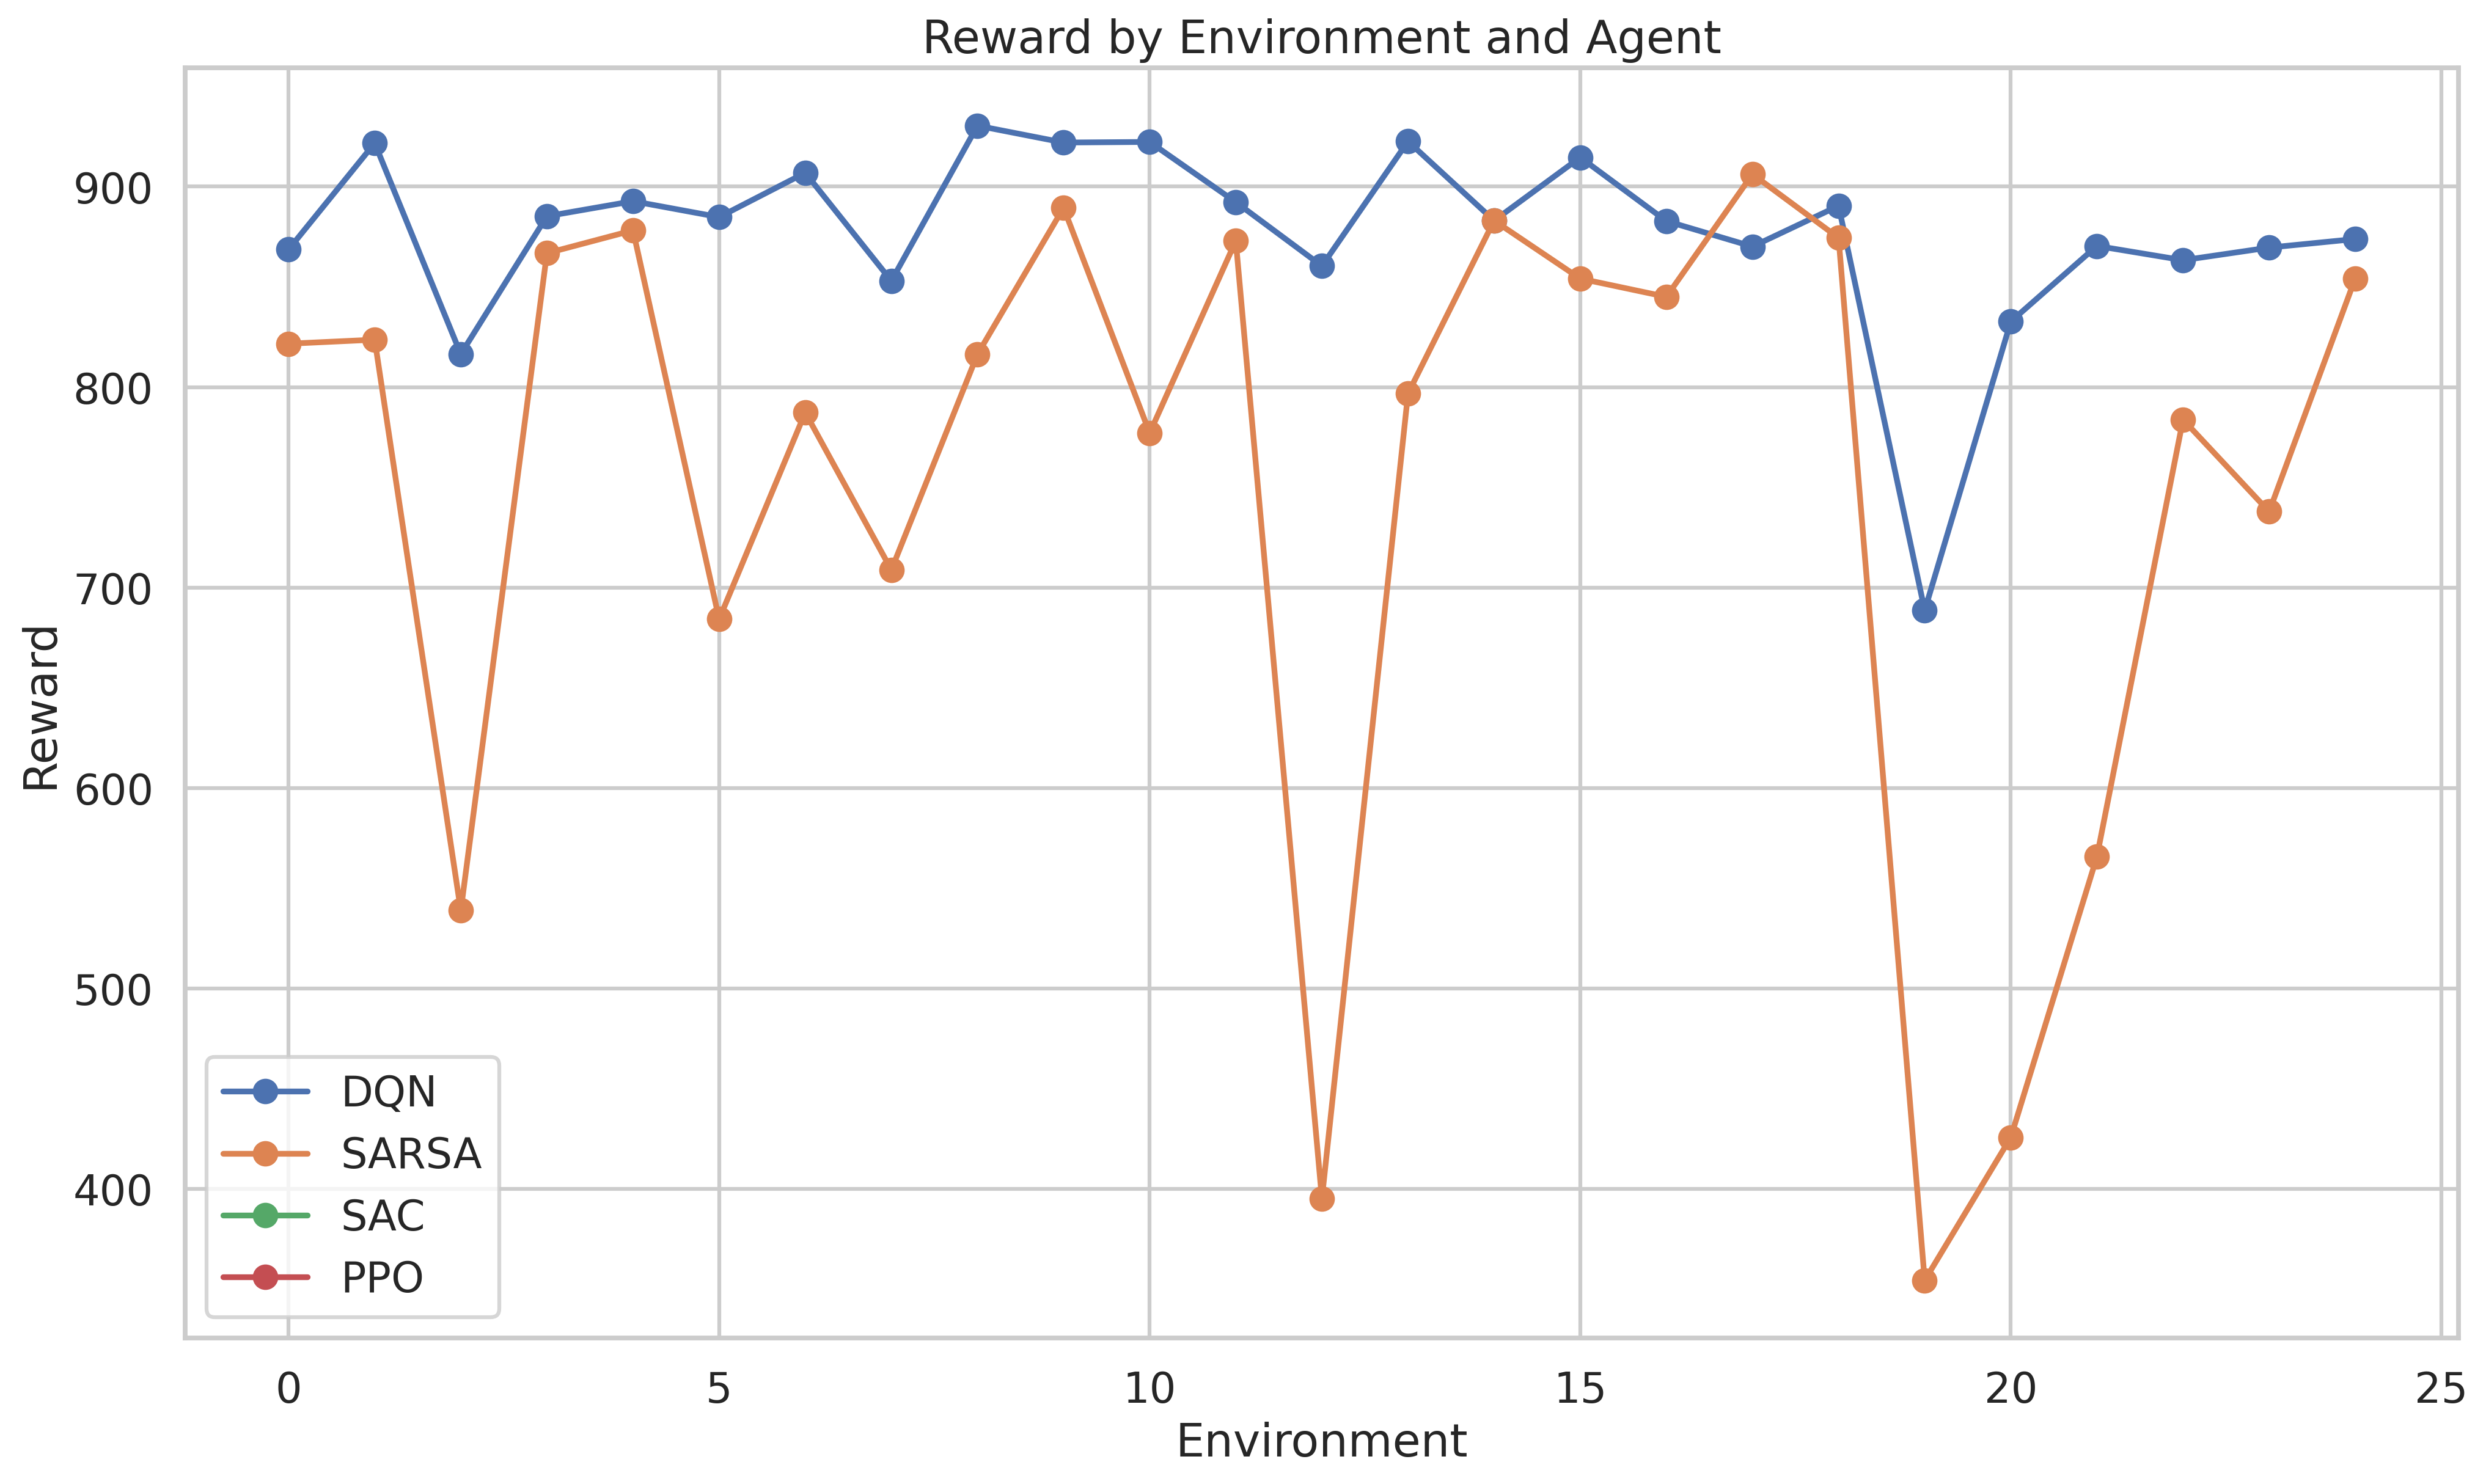

In [ ]:
df = pd.read_csv('benchmark.csv')
grouped = df.groupby(['agent', 'environment'])['reward'].agg(['min', 'max', 'mean']).reset_index()
grouped = grouped[grouped['agent'].isin(['DQN', 'SARSA'])]

print(grouped)
# Plotting
plt.figure(figsize=(16, 9), dpi=300)
for agent in df['agent'].unique():
    agent_data = grouped[grouped['agent'] == agent]
    plt.plot(agent_data['environment'], agent_data['mean'], label=f'{agent}', marker='o')
    plt.fill_between(agent_data['environment'], agent_data['min'], agent_data['max'], alpha=0.2)

# Add labels and title
plt.xlabel('Environment')
plt.ylabel('Reward')
plt.title('Reward by Environment and Agent')
plt.legend()
plt.grid(True)
plt.show()

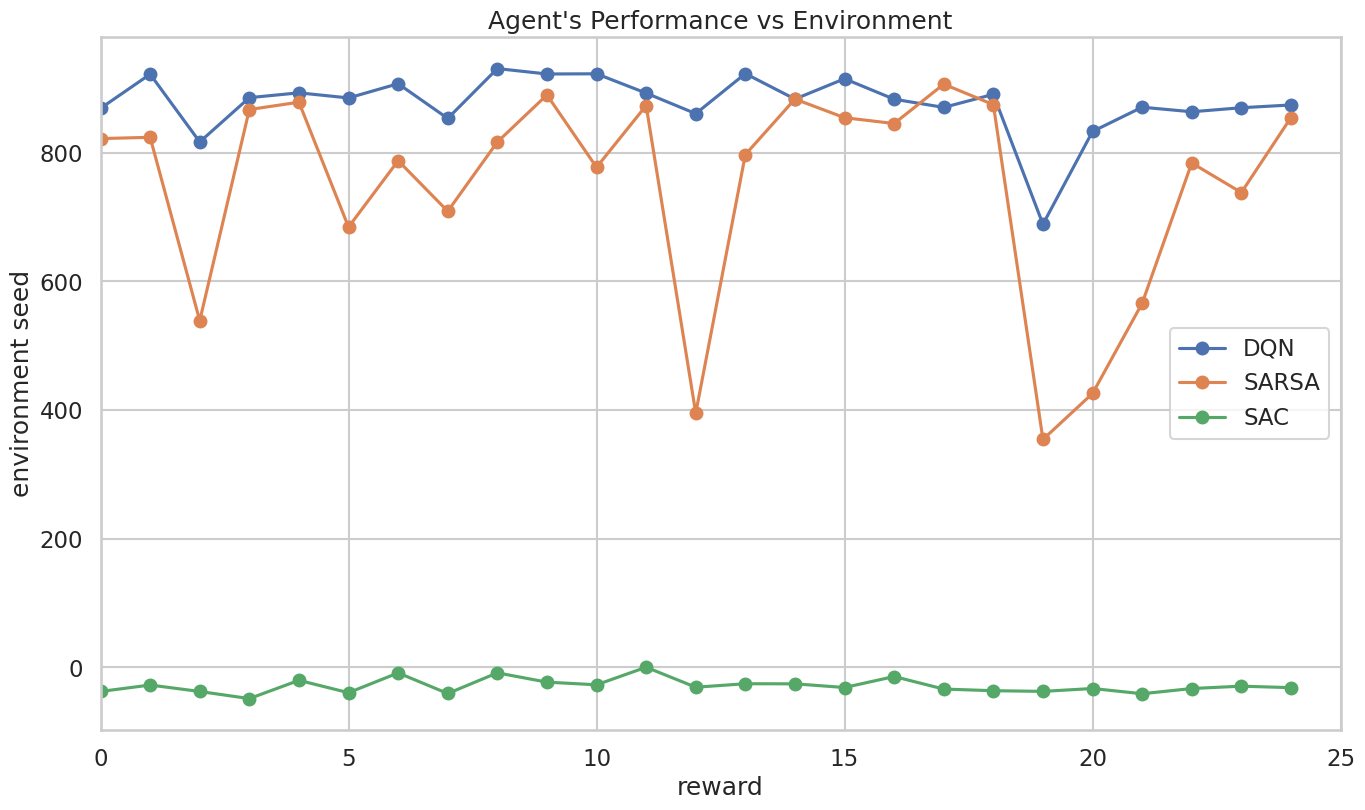

In [ ]:
indices = range(len(scores_DQN))

# Plot each array against the indices
plt.figure(figsize=(16,9))
plt.plot(indices, scores_DQN, marker='o', label='[D] DQN')
plt.fill_between(indices, scores_DQN_min, scores_DQN_max, alpha=0.2)
plt.plot(indices, scores_SARSA, marker='o', label='[D] SARSA')
plt.plot(indices, scores_SAC, marker='o', label='[C] SAC')
# Add labels and legend
plt.xlim(left=0, right=25)
plt.ylim(down=-250, up=1000)
plt.xlabel('reward')
plt.ylabel('environment seed')
plt.title('Agent\'s Performance vs Environment')
plt.legend()
# plt.tight_layout()



# Show the plot
plt.show()